In [1]:
import cv2
import mediapipe as mp
import time
import matplotlib.pyplot as plt
import numpy as np
import itertools
import matplotlib.animation as animation
from matplotlib import style
from IPython.display import display, clear_output
from scipy.signal import filtfilt, butter, lfilter, medfilt
from matplotlib import pyplot as plt 
import math
from scipy import stats

In [2]:
import pandas as pd
df = pd.DataFrame(columns=("name", "SNR", "STD", "powerSNR", "powerSTD", "dxSNR", "dxSTD", "isReal"))
df

,name,SNR,STD,powerSNR,powerSTD,dxSNR,dxSTD,isReal


In [3]:
def polygon(image, coordinates, facial_landmarks):
    height, width, _ = image.shape

    area = []
    for i in coordinates:
        pt1 = facial_landmarks.landmark[i]
        x = int(pt1.x * width)
        y = int(pt1.y * height)
        area.append([x,y])
        #cv2.circle(image, (x, y), 2, (100, 100, 0), -1)
        #cv2.putText(image, str(i), (x, y), 0, 0.5, (0, 0, 0))
        
    area = np.array(area)
    area = area.reshape((-1, 1, 2))
    #cv2.polylines(image,[area],True,(0,255,255))
    
    return area

In [4]:
def extract_roi(image, yanak_sag , yanak_sol, alin):
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [yanak_sag], -1, (255, 255, 255), -1, cv2.LINE_AA)
    cv2.drawContours(mask, [yanak_sol], -1, (255, 255, 255), -1, cv2.LINE_AA)
    cv2.drawContours(mask, [alin], -1, (255, 255, 255), -1, cv2.LINE_AA)

    output = cv2.bitwise_and(image, image, mask=mask)
    return output

In [5]:
def green(image, area):
    mask_G = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask_G, [area], -1, (255, 255, 255), -1, cv2.LINE_AA)
    mean = cv2.mean(image[:,:,1], mask=mask_G)
    #print(f"{txt}= {mean}")
    return mean

In [6]:
def update_signal(green_mean, green_arr, n_frames, hepsi):
    
    if len(green_arr) < n_frames:
        green_arr.append(green_mean)
    else:
        del green_arr[0]
        green_arr.append(green_mean)
        
    hepsi.append(green_mean)

In [7]:
def nabiz_bul(mean_list, fps, hz_bottom, hz_top):
    sampling_rate = fps
    raw_signal = np.squeeze(mean_list) 
    normalized_signal = raw_signal - np.mean(raw_signal)
    normalized_signal = normalized_signal / np.std(normalized_signal)
    med_signal = medfilt(normalized_signal, 5)
    nyq = 0.5 * sampling_rate
    low = hz_bottom / nyq
    high = hz_top / nyq

    b, a = butter(3, [low, high], btype = 'band')
    filtered_signal = lfilter(b, a, med_signal)
    window = np.hamming(len(filtered_signal))
    windowed_signal = filtered_signal * window
    def nextpow(x):
        return 2 ** math.ceil(math.log2(x))

    NFFT = nextpow(len(windowed_signal) * sampling_rate)
    freqDomain = np.fft.fft(windowed_signal, NFFT)
    conj = np.conjugate(freqDomain)

    powerSpectrum = np.multiply(freqDomain, conj) / NFFT
    powerSpectrum = np.real(powerSpectrum)

    freqInterestL = hz_bottom
    freqInterestH = hz_top

    freqs = np.linspace(0, sampling_rate, NFFT)
    fRange = list()

    for i in range(len(freqs)):
        if freqs[i] < freqInterestH and freqs[i] > freqInterestL:
            fRange.append(i + 1)

    HRange = list()
    for i in range(len(fRange)):
        idx = 60 * freqs[fRange[i]]
        HRange.append(idx)
    max_x = HRange[powerSpectrum[fRange].argmax()]
    return max_x

In [8]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [9]:
def power_spectrum(mean_list, fps, hz_bottom, hz_top):
    sampling_rate = fps
    raw_signal = np.squeeze(mean_list) 
    normalized_signal = raw_signal - np.mean(raw_signal)
    normalized_signal = normalized_signal / np.std(normalized_signal)
    med_signal = medfilt(normalized_signal, 5)
    nyq = 0.5 * sampling_rate
    low = hz_bottom / nyq
    high = hz_top / nyq

    b, a = butter(3, [low, high], btype = 'band')
    filtered_signal = lfilter(b, a, med_signal)
    window = np.hamming(len(filtered_signal))
    windowed_signal = filtered_signal * window
    def nextpow(x):
        return 2 ** math.ceil(math.log2(x))

    NFFT = nextpow(len(windowed_signal) * sampling_rate)
    freqDomain = np.fft.fft(windowed_signal, NFFT)
    conj = np.conjugate(freqDomain)

    powerSpectrum = np.multiply(freqDomain, conj) / NFFT
    powerSpectrum = np.real(powerSpectrum)
    return powerSpectrum

In [10]:
def pre_train(array):
    snr = signaltonoise(array)
    std = np.std(array)
    ps = power_spectrum(array, fps, 1.0, 2.75)
    powerSNR = signaltonoise(ps)
    powerSTD = np.std(ps)
    dx = np.diff(array)
    dxSNR = signaltonoise(dx)
    dxSTD = np.std(dx)
     
    return {"name" : name,
            "SNR" : float(snr), 
            "STD" : std, 
            "powerSNR" : float(powerSNR), 
            "powerSTD" : powerSTD, 
            "dxSNR" : float(dxSNR), 
            "dxSTD" : dxSTD,
            "isReal" : 0}


In [11]:
hepsi = []
def start_video():
    cap = cv2.VideoCapture(path)
    global fps
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
    if int(major_ver)  < 3 :
        fps = cap.get(cv2.cv.CV_CAP_PROP_FPS)
    else :
        fps = cap.get(cv2.CAP_PROP_FPS)
    

    font = cv2.FONT_HERSHEY_SIMPLEX 

    # Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()

    green_arr = []
    nabiz = []
    
    start = time.time()
    
    ctr = 0
    while True:
        ret, image = cap.read()
        if ret is not True:
            break


        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Facial landmarks
        result = face_mesh.process(rgb_image)
        
        try:

            for facial_landmarks in result.multi_face_landmarks:
                yanak_sol_arr = [143, 123, 147, 213, 138, 135, 210, 202, 57, 92, 36, 101, 118, 31, 143]
                yanak_sol = polygon(image, yanak_sol_arr, facial_landmarks)

            for facial_landmarks in result.multi_face_landmarks:

                yanak_sag_arr = [372, 352, 376, 433, 367, 364, 430, 422, 287, 322, 266, 330, 347, 261, 372]
                yanak_sag = polygon(image, yanak_sag_arr, facial_landmarks)

            for facial_landmarks in result.multi_face_landmarks:

                alin_arr = [54, 103, 67, 109, 10, 338, 297, 332, 284, 298, 296, 9, 66, 68,]
                alin = polygon(image, alin_arr, facial_landmarks)

            image = extract_roi(image, yanak_sag , yanak_sol, alin)
            mean_yanak_sag = green(image, yanak_sag)[0]
            mean_yanak_sol = green(image, yanak_sol)[0]
            mean_alin = green(image, alin)[0]
            
            mean_raw = (mean_yanak_sag + mean_yanak_sol + mean_alin)/3
            update_signal(mean_raw, green_arr, n_frames=fps*10, hepsi=hepsi)
                  
        except:
            text = "No Face Detected"
            coordinates = (128,128)
            fontScale = 1
            color = (255,0,255)
            thickness = 2
            blank = np.zeros(image.shape[:2], dtype="uint8")
            image = cv2.putText(blank, text, coordinates, font, fontScale, color, thickness, cv2.LINE_AA)

        cv2.imshow(path, image)
        ctr += 1
        if cv2.waitKey(1) == ord("q"):
            break   

    cap.release()
    cv2.destroyAllWindows()

30.007671545497224


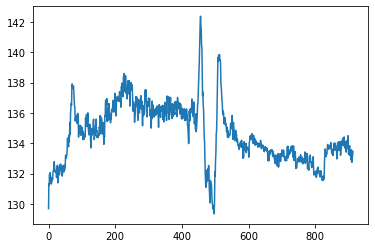

{'name': 'sahte_1', 'SNR': 69.52107891349767, 'STD': 1.9366676111569538, 'powerSNR': 0.18185754304364146, 'powerSTD': 0.007650466963954271, 'dxSNR': 0.008312145072496873, 'dxSTD': 0.4943147107776469, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


29.975004485536235


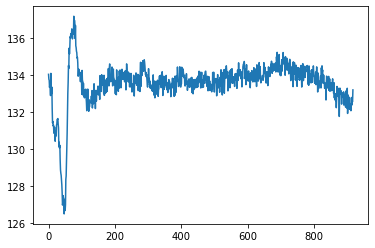

{'name': 'sahte_2', 'SNR': 111.45739058297593, 'STD': 1.1985335023848034, 'powerSNR': 0.2879397633119464, 'powerSTD': 0.0004930243003933651, 'dxSNR': -0.0019420270834168561, 'dxSTD': 0.4731597626456996, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00769177638086


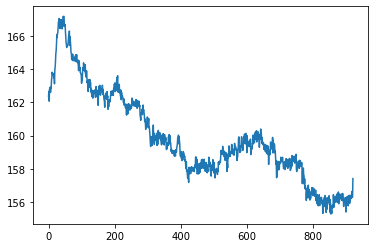

{'name': 'sahte_3', 'SNR': 58.54753043144046, 'STD': 2.7306945435374246, 'powerSNR': 0.2790883920720787, 'powerSTD': 0.00013447691140821446, 'dxSNR': -0.01532852358069524, 'dxSTD': 0.3499364053201485, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00768755896707


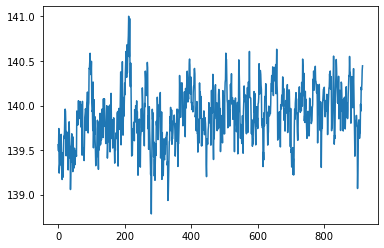

{'name': 'sahte_4', 'SNR': 445.00700797638376, 'STD': 0.3143508834496559, 'powerSNR': 0.2750233759019009, 'powerSTD': 0.008108432167831614, 'dxSNR': 0.004172343021518332, 'dxSTD': 0.23218266765586776, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.007671545497224


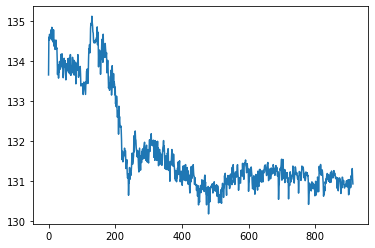

{'name': 'sahte_5', 'SNR': 107.42881685683247, 'STD': 1.2271272379490248, 'powerSNR': 0.22516642900246017, 'powerSTD': 0.0003094843451251532, 'dxSNR': -0.01460971135562608, 'dxSTD': 0.20366496409596146, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00769343854387


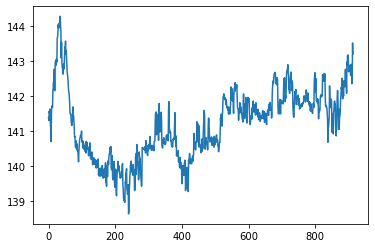

{'name': 'sahte_6', 'SNR': 141.49386287056566, 'STD': 0.9977769806832236, 'powerSNR': 0.27303228060692547, 'powerSTD': 0.0009193381309982868, 'dxSNR': 0.008091583423214468, 'dxSTD': 0.24583923857014447, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00769343854387


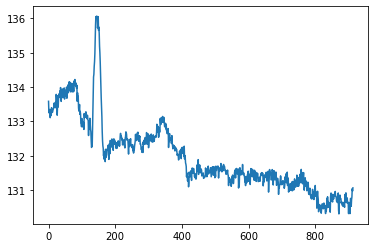

{'name': 'sahte_7', 'SNR': 123.77314541796117, 'STD': 1.066372530585654, 'powerSNR': 0.23178916910408617, 'powerSTD': 0.00033152915694946455, 'dxSNR': -0.016952883667100252, 'dxSTD': 0.16290641882706633, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00768755896707


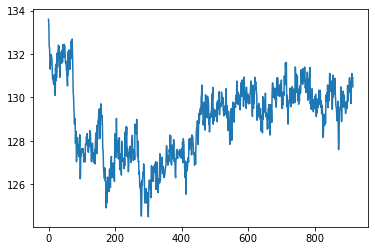

{'name': 'sahte_8', 'SNR': 76.47195104433362, 'STD': 1.6858290421501192, 'powerSNR': 0.23785264764151343, 'powerSTD': 0.0012743628673643505, 'dxSNR': -0.006297994714996709, 'dxSTD': 0.5396310572505059, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00767409370265


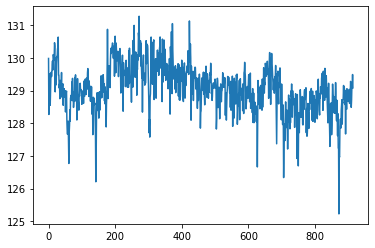

{'name': 'sahte_9', 'SNR': 180.56695514539945, 'STD': 0.7147849184153926, 'powerSNR': 0.24492369956329246, 'powerSTD': 0.003850608676703149, 'dxSNR': -0.0017198742469267665, 'dxSTD': 0.5725409043183568, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.007685028260425


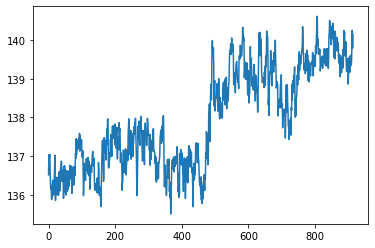

{'name': 'sahte_10', 'SNR': 106.16873433179248, 'STD': 1.299461546892589, 'powerSNR': 0.23226474781517945, 'powerSTD': 0.001958873103566031, 'dxSNR': 0.011304742845106677, 'dxSTD': 0.35154620415703275, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00769343854387


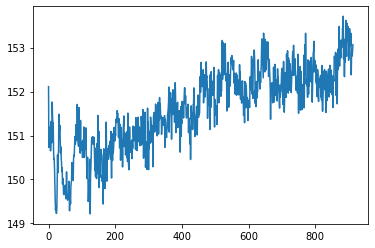

{'name': 'sahte_11', 'SNR': 169.22286627149242, 'STD': 0.895933007095176, 'powerSNR': 0.26022344602829184, 'powerSTD': 0.0010948083052153288, 'dxSNR': 0.002549580517029172, 'dxSTD': 0.41047470196176344, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00767409370265


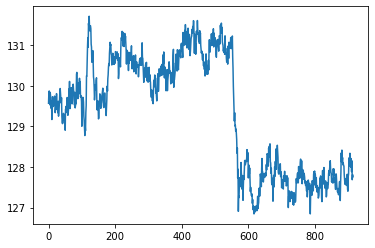

{'name': 'sahte_12', 'SNR': 90.76719496388431, 'STD': 1.42509528510822, 'powerSNR': 0.2711663437603996, 'powerSTD': 0.0003586392576292659, 'dxSNR': -0.008760264876783198, 'dxSTD': 0.22626419695912475, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00769008415461


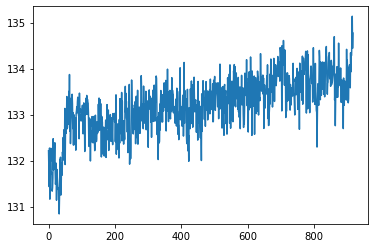

{'name': 'sahte_13', 'SNR': 212.8419970763989, 'STD': 0.6258388579286049, 'powerSNR': 0.2570594043203189, 'powerSTD': 0.0021490397196271046, 'dxSNR': 0.005563818482083405, 'dxSTD': 0.502431737425992, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.007671545497224


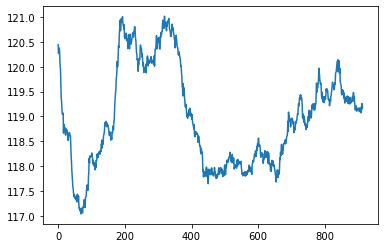

{'name': 'sahte_14', 'SNR': 118.65777669199967, 'STD': 1.0026769917051326, 'powerSNR': 0.243496059863277, 'powerSTD': 0.00017584101014250187, 'dxSNR': -0.014932913611212361, 'dxSTD': 0.0917580439752795, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00768755896707


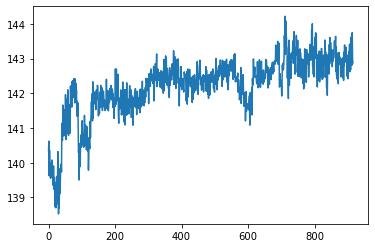

{'name': 'sahte_15', 'SNR': 162.13921941352112, 'STD': 0.8770399073393862, 'powerSNR': 0.24949459408942246, 'powerSTD': 0.0008513958150260089, 'dxSNR': 0.006019173659164815, 'dxSTD': 0.4594404858169477, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.007690908732357


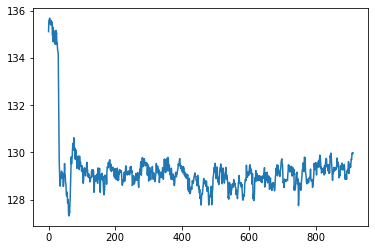

{'name': 'sahte_16', 'SNR': 110.40176365386458, 'STD': 1.170510514268238, 'powerSNR': 0.22841496958305246, 'powerSTD': 0.0009877334223257054, 'dxSNR': -0.022451231196290358, 'dxSTD': 0.2502914449688644, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.007685028260425


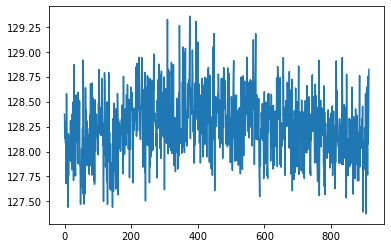

{'name': 'sahte_17', 'SNR': 389.749128553298, 'STD': 0.3290714906380704, 'powerSNR': 0.22704516288095156, 'powerSTD': 0.00642591277660398, 'dxSNR': 0.0011087635982414633, 'dxSTD': 0.4438540005834981, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.007671545497224


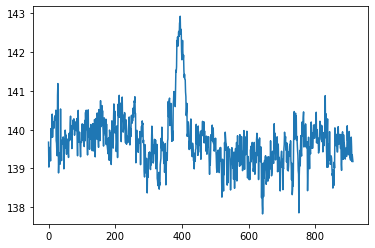

{'name': 'sahte_18', 'SNR': 207.77622553715662, 'STD': 0.6723240085264734, 'powerSNR': 0.23421710528135253, 'powerSTD': 0.0043992304740084935, 'dxSNR': -0.0013902008495577226, 'dxSTD': 0.3923522099334565, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00769008415461


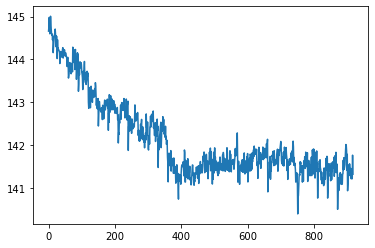

{'name': 'sahte_19', 'SNR': 152.14687064344216, 'STD': 0.9342011331941174, 'powerSNR': 0.25005448131501645, 'powerSTD': 0.00039970928946547605, 'dxSNR': -0.01500495458787655, 'dxSTD': 0.24306418034294827, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.007685832448853


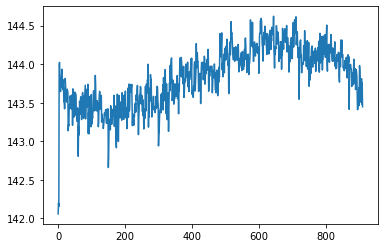

{'name': 'sahte_20', 'SNR': 382.37423968041793, 'STD': 0.3761603446711557, 'powerSNR': 0.20338308094065607, 'powerSTD': 0.003184569763579782, 'dxSNR': 0.00803188895274637, 'dxSTD': 0.18997169898631752, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.007672291303784


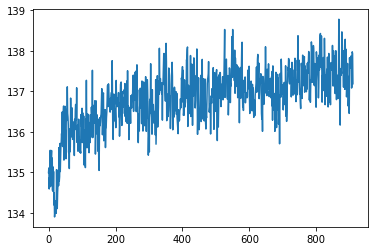

{'name': 'sahte_21', 'SNR': 180.97835054839067, 'STD': 0.7560248085188459, 'powerSNR': 0.29325622155846187, 'powerSTD': 0.003034366319484092, 'dxSNR': 0.004236838941034081, 'dxSTD': 0.5695496407521481, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00768755896707


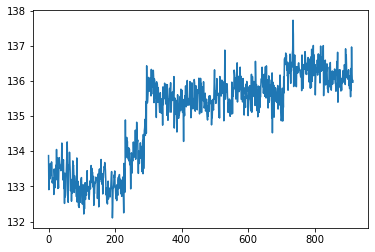

{'name': 'sahte_22', 'SNR': 106.37891029552466, 'STD': 1.269246551816163, 'powerSNR': 0.2392264151624839, 'powerSTD': 0.0004946417228538771, 'dxSNR': 0.005178235184295193, 'dxSTD': 0.4421238788322385, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


29.97496632179457


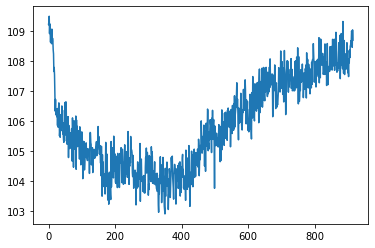

{'name': 'sahte_23', 'SNR': 69.46314071715838, 'STD': 1.5247329579606863, 'powerSNR': 0.2743093778268665, 'powerSTD': 0.0005150567671241673, 'dxSNR': -0.000970422081257471, 'dxSTD': 0.5972038198968237, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.007692603841072


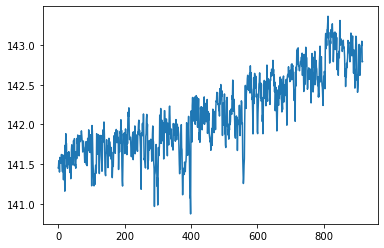

{'name': 'sahte_24', 'SNR': 285.69840965205475, 'STD': 0.49750646918692754, 'powerSNR': 0.2660355944031929, 'powerSTD': 0.0027237694515504477, 'dxSNR': 0.007955930742324148, 'dxSTD': 0.18370155469699984, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.007671545497224


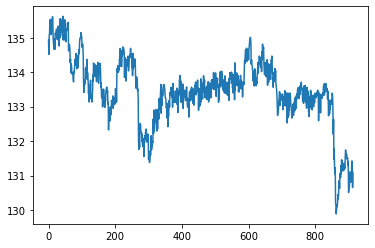

{'name': 'sahte_25', 'SNR': 136.2127508164451, 'STD': 0.9798763708510572, 'powerSNR': 0.21695773726105932, 'powerSTD': 0.0010425970515062014, 'dxSNR': -0.013837691541921587, 'dxSTD': 0.30487982716843237, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.00769008415461


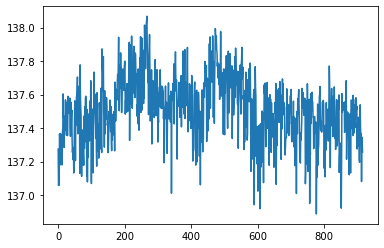

{'name': 'sahte_26', 'SNR': 715.9783386234753, 'STD': 0.19205930976907087, 'powerSNR': 0.2503311240133824, 'powerSTD': 0.004195041656985745, 'dxSNR': -9.566835878263e-05, 'dxSTD': 0.1866110758629064, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.36419606844825986


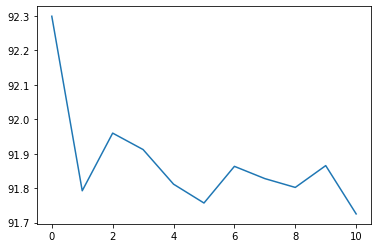

Error occured in27th iteration!!
34.752398784601134


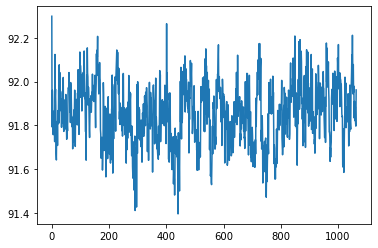

{'name': 'sahte_28', 'SNR': 663.1224541053076, 'STD': 0.1385199664207874, 'powerSNR': 0.2626276699550394, 'powerSTD': 0.003873340632929054, 'dxSNR': -0.002641269773737329, 'dxSTD': 0.12001925068349988, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.39624128452619084


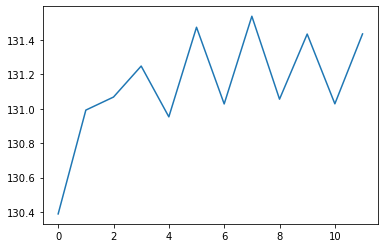

Error occured in29th iteration!!
40.987991218376926


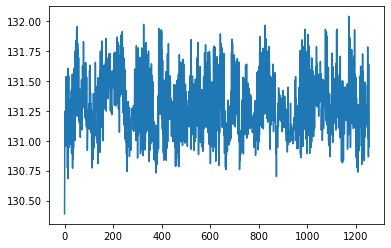

{'name': 'sahte_30', 'SNR': 479.9200953935893, 'STD': 0.27356204360897746, 'powerSNR': 0.20307637674479817, 'powerSTD': 0.003598937714338366, 'dxSNR': 0.0010703321087569997, 'dxSTD': 0.4189109679595657, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.39734207584009335


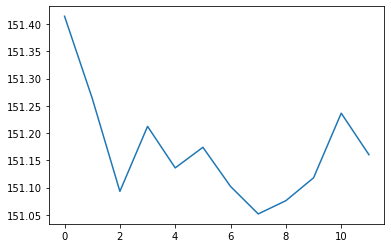

Error occured in31th iteration!!
44.90288026373411


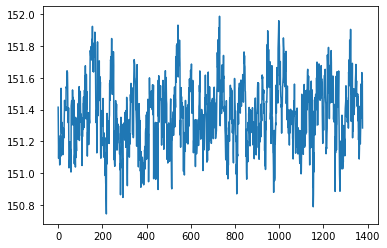

{'name': 'sahte_32', 'SNR': 741.9291808064798, 'STD': 0.20401824276579172, 'powerSNR': 0.21350381756358291, 'powerSTD': 0.008167010456350083, 'dxSNR': -0.0006396348555494994, 'dxSTD': 0.14792355940296598, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.39564801833462226


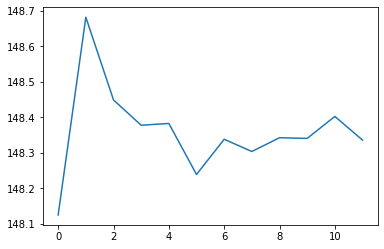

Error occured in33th iteration!!
50.84614176195914


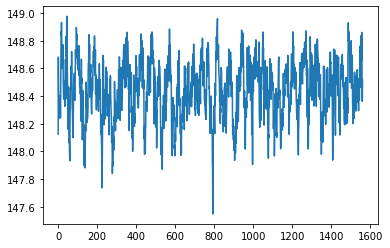

{'name': 'sahte_34', 'SNR': 710.2450209980057, 'STD': 0.2090032494259856, 'powerSNR': 0.19219678277983399, 'powerSTD': 0.008586980682029049, 'dxSNR': 0.0019426429499488642, 'dxSTD': 0.1282447118068893, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.3630841023809148


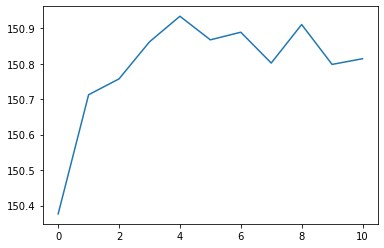

Error occured in35th iteration!!
46.07256538432089


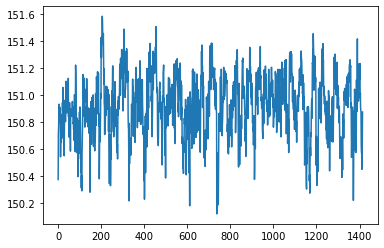

{'name': 'sahte_36', 'SNR': 669.0715268511334, 'STD': 0.2255674038639904, 'powerSNR': 0.2051986715318063, 'powerSTD': 0.011064665881285782, 'dxSNR': 0.0022201300582532515, 'dxSTD': 0.15907038936742596, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.42916471341700946


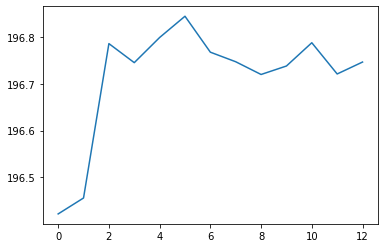

Error occured in37th iteration!!
51.59324569645773


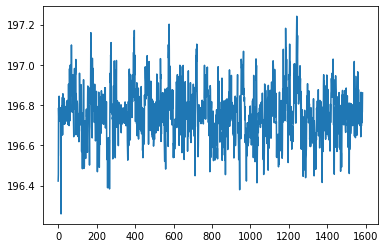

{'name': 'sahte_38', 'SNR': 1544.6803353748153, 'STD': 0.12737838686216468, 'powerSNR': 0.2069688772797892, 'powerSTD': 0.0046905824924646, 'dxSNR': 0.0022783851694642876, 'dxSTD': 0.12166213078397349, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


1.2195510513958365


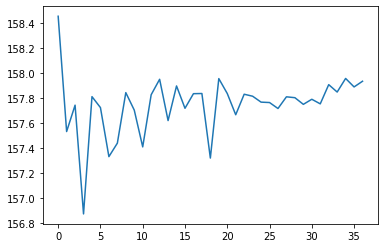

Error occured in39th iteration!!
50.35198698662526


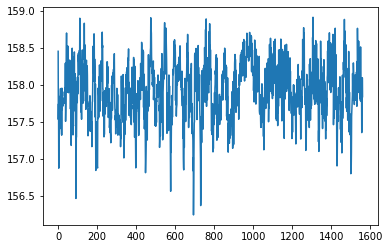

{'name': 'sahte_40', 'SNR': 400.14430932527245, 'STD': 0.39465428244265116, 'powerSNR': 0.2172416604641771, 'powerSTD': 0.0071197102604814, 'dxSNR': -0.0011638304314171934, 'dxSTD': 0.33794695537324243, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.3945721486134077


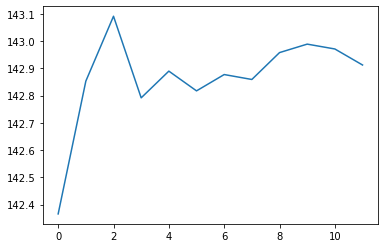

Error occured in41th iteration!!
46.37201901310999


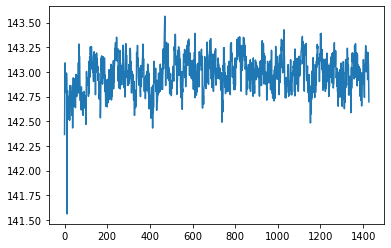

{'name': 'sahte_42', 'SNR': 824.2596901624297, 'STD': 0.1734649843250811, 'powerSNR': 0.21251757086417955, 'powerSTD': 0.003679803978853485, 'dxSNR': 0.0015228027544832044, 'dxSTD': 0.15222277001258422, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.3945574453720604


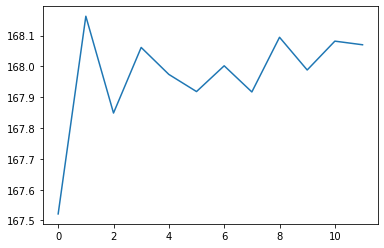

Error occured in43th iteration!!
52.70113442851658


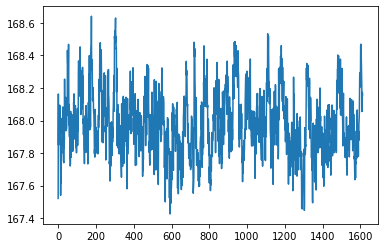

{'name': 'sahte_44', 'SNR': 831.1360532402377, 'STD': 0.202107811941939, 'powerSNR': 0.14400199369575506, 'powerSTD': 0.007551473471586661, 'dxSNR': 0.0028321028483650266, 'dxSTD': 0.13941017555465804, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.3944562821911024


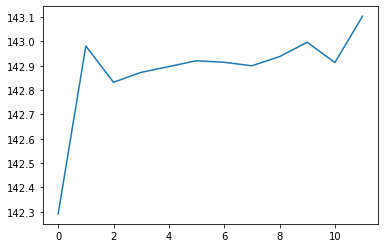

Error occured in45th iteration!!
49.67228500141158


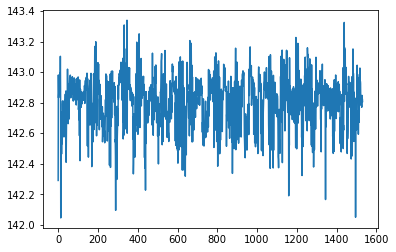

{'name': 'sahte_46', 'SNR': 853.3738710225431, 'STD': 0.16733755980636836, 'powerSNR': 0.18502350565696915, 'powerSTD': 0.005088474871535191, 'dxSNR': 0.0016725561346478076, 'dxSTD': 0.20180049887375237, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.3905341748139448


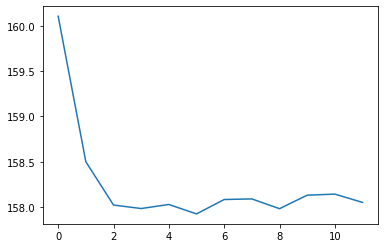

Error occured in47th iteration!!
53.3870770520726


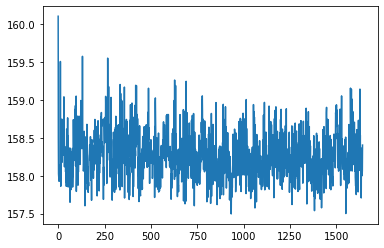

{'name': 'sahte_48', 'SNR': 511.5141562519372, 'STD': 0.3094117009902726, 'powerSNR': 0.17581212069600016, 'powerSTD': 0.0034728422946509493, 'dxSNR': -0.002563472540225569, 'dxSTD': 0.40443135676310193, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


0.3644002321855217


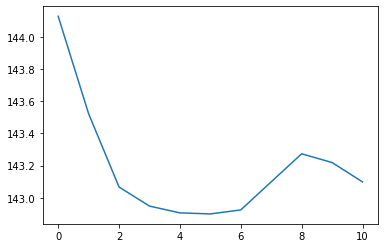

Error occured in49th iteration!!
50.87499131045636


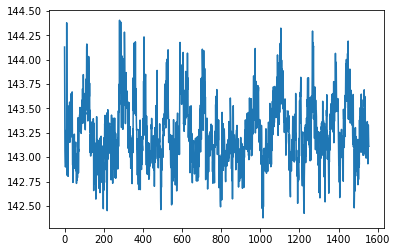

{'name': 'sahte_50', 'SNR': 429.0966348662787, 'STD': 0.333840324611381, 'powerSNR': 0.18406024100050952, 'powerSTD': 0.003783393536527049, 'dxSNR': -0.0024029923581440175, 'dxSTD': 0.2724567000221254, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.058552234069836


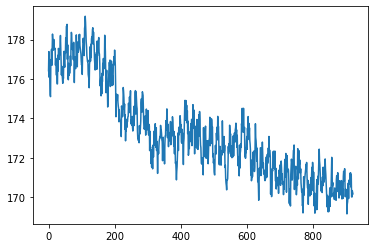

{'name': 'sahte_51', 'SNR': 72.5733324739505, 'STD': 2.3875585362843412, 'powerSNR': 0.08422885244614393, 'powerSTD': 0.00649111402002614, 'dxSNR': -0.010181064187672208, 'dxSTD': 0.6668926296137556, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.06113080604389


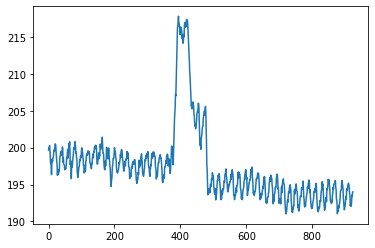

{'name': 'sahte_52', 'SNR': 39.52189002299991, 'STD': 4.9951451603835695, 'powerSNR': 0.1417955876112842, 'powerSTD': 0.005214269712111321, 'dxSNR': -0.009279991985358508, 'dxSTD': 0.6618719699985397, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.07314206103879


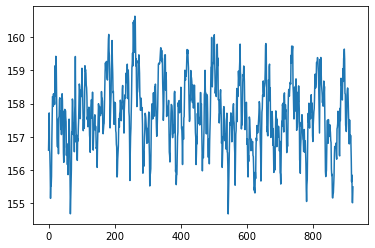

{'name': 'sahte_53', 'SNR': 152.27123672629546, 'STD': 1.0354737248953325, 'powerSNR': 0.09965906295387678, 'powerSTD': 0.02539387488092377, 'dxSNR': -0.002363455740284143, 'dxSTD': 0.5098435639073148, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.06356853909238


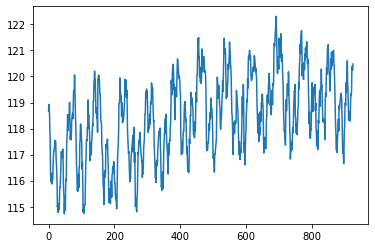

{'name': 'sahte_54', 'SNR': 75.54219620519041, 'STD': 1.5673270253194997, 'powerSNR': 0.07759879460781649, 'powerSTD': 0.029471890776942396, 'dxSNR': 0.004156217733359741, 'dxSTD': 0.46780278819813825, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.063405865718952


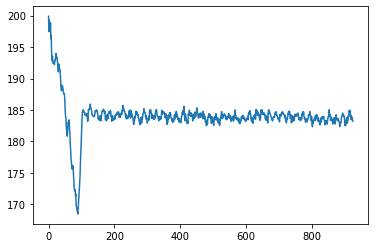

{'name': 'sahte_55', 'SNR': 60.66709499042139, 'STD': 3.0329101194251264, 'powerSNR': 0.09044041891659532, 'powerSTD': 0.0019439983336386904, 'dxSNR': -0.03603930146128107, 'dxSTD': 0.5002416149219145, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.061196006155388


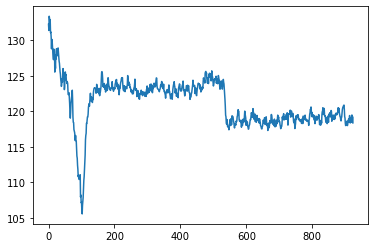

{'name': 'sahte_56', 'SNR': 35.57517922949391, 'STD': 3.406032118135055, 'powerSNR': 0.2064155708483689, 'powerSTD': 0.0010024613892071817, 'dxSNR': -0.026972830211248175, 'dxSTD': 0.5569327847216771, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.061098206094204


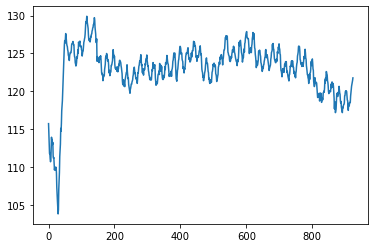

{'name': 'sahte_57', 'SNR': 35.392188160681336, 'STD': 3.472969062219915, 'powerSNR': 0.08021353068832923, 'powerSTD': 0.007697898255108913, 'dxSNR': 0.012160118069852984, 'dxSTD': 0.5370956648489807, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.07665641326107


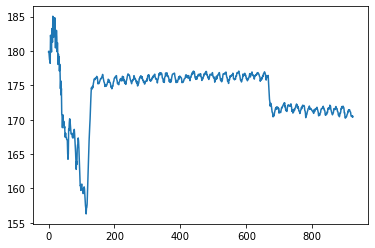

{'name': 'sahte_58', 'SNR': 43.76745656283447, 'STD': 3.9737688414118537, 'powerSNR': 0.10019586710021876, 'powerSTD': 0.0008605002416981492, 'dxSNR': -0.01926843640225192, 'dxSTD': 0.53170683944414, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.078203328654503


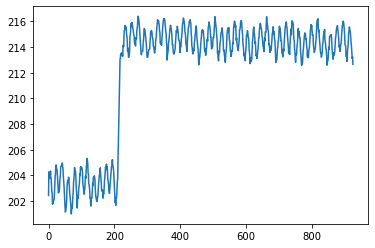

{'name': 'sahte_59', 'SNR': 44.1425670718789, 'STD': 4.801377798386565, 'powerSNR': 0.07020806244611456, 'powerSTD': 0.00403856631550301, 'dxSNR': 0.02944275382264593, 'dxSTD': 0.37559228542413126, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.08053926478446


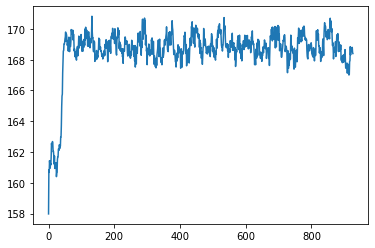

{'name': 'sahte_60', 'SNR': 103.39472233704278, 'STD': 1.6304082457222313, 'powerSNR': 0.09728953792349686, 'powerSTD': 0.0057524180033066055, 'dxSNR': 0.022360141264868395, 'dxSTD': 0.5034236362872779, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.074174264944126


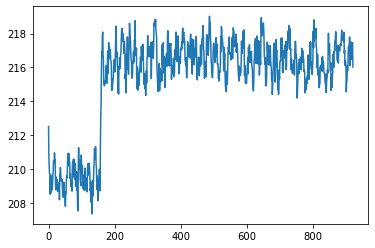

{'name': 'sahte_61', 'SNR': 76.56862376877433, 'STD': 2.8123854503366963, 'powerSNR': 0.10310264917888205, 'powerSTD': 0.005538774583336263, 'dxSNR': 0.005268637870192389, 'dxSTD': 0.7239189813979378, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.067125099522507


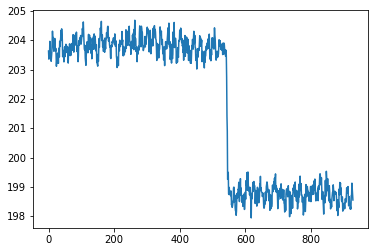

{'name': 'sahte_62', 'SNR': 79.92383264826161, 'STD': 2.523823662660497, 'powerSNR': 0.16472686967016476, 'powerSTD': 0.0007148900169646356, 'dxSNR': -0.018739516336501283, 'dxSTD': 0.2925275726126284, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.068575751795223


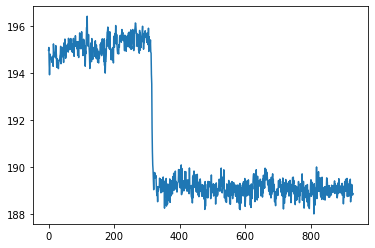

{'name': 'sahte_63', 'SNR': 66.1472626071692, 'STD': 2.8897464809465068, 'powerSNR': 0.2575096983041785, 'powerSTD': 0.0002618894654124843, 'dxSNR': -0.014438070433522894, 'dxSTD': 0.45544027931300995, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.061098206094204


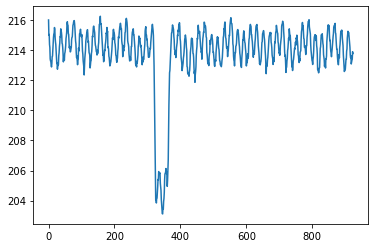

{'name': 'sahte_64', 'SNR': 100.12285099097997, 'STD': 2.1360158060590364, 'powerSNR': 0.09039068061502992, 'powerSTD': 0.022597873239430598, 'dxSNR': -0.00638617543890315, 'dxSTD': 0.3782717334197988, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


15.016151281507971


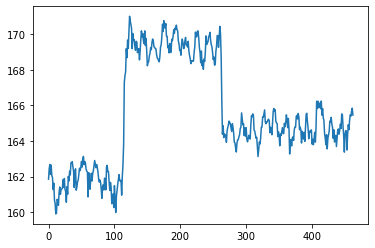

{'name': 'sahte_65', 'SNR': 55.30175579032011, 'STD': 2.9919913357066332, 'powerSNR': 0.2583518888379838, 'powerSTD': 0.001196361780964025, 'dxSNR': 0.015066533110460306, 'dxSTD': 0.5169278640164111, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


30.07200520861312


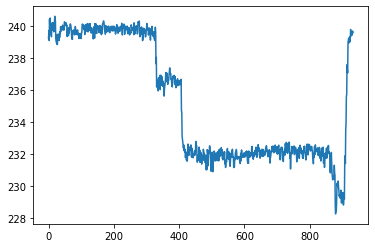

{'name': 'sahte_66', 'SNR': 62.4394630218271, 'STD': 3.7669767789022366, 'powerSNR': 0.2792904248539095, 'powerSTD': 0.00017200827884050594, 'dxSNR': 0.0010025530095322391, 'dxSTD': 0.38496551065580836, 'isReal': 0}


C:\Users\ahmet\AppData\Local\Temp\ipykernel_20384\3512133229.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [12]:
for i in range(66):

    try:
        name = "sahte_" + str(i+1)
        path = r"C:\Users\ahmet\OneDrive\Masaüstü\yüz videoları\videolar\sahte"
        path += "\\" + name + ".mp4"
        start_video()
        print(fps)
        plt.plot(hepsi)
        plt.show()
        new_row = pre_train(array=hepsi)
        print(new_row)
        df = df.append(new_row, ignore_index=True)
        hepsi = []
    except:
        print("Error occured in" + str(i+1) + "th iteration!!")


In [13]:
df

,name,SNR,STD,powerSNR,powerSTD,dxSNR,dxSTD,isReal
0,sahte_1,69.521079,1.936668,0.181858,0.00765,0.008312,0.494315,0
1,sahte_2,111.457391,1.198534,0.28794,0.000493,-0.001942,0.47316,0
2,sahte_3,58.54753,2.730695,0.279088,0.000134,-0.015329,0.349936,0
3,sahte_4,445.007008,0.314351,0.275023,0.008108,0.004172,0.232183,0
4,sahte_5,107.428817,1.227127,0.225166,0.000309,-0.01461,0.203665,0
5,sahte_6,141.493863,0.997777,0.273032,0.000919,0.008092,0.245839,0
6,sahte_7,123.773145,1.066373,0.231789,0.000332,-0.016953,0.162906,0
7,sahte_8,76.471951,1.685829,0.237853,0.001274,-0.006298,0.539631,0
8,sahte_9,180.566955,0.714785,0.244924,0.003851,-0.00172,0.572541,0
9,sahte_10,106.168734,1.299462,0.232265,0.001959,0.011305,0.351546,0


In [14]:
df.to_csv('sahte.csv', index=False)